In [1]:
import os
import re
import glob
import numpy as np
import pandas as pd
from copy import deepcopy

import cv2
from PIL import Image

from tqdm import tqdm

import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from torch import optim
from torch.utils.data import TensorDataset, DataLoader, Dataset

import torchvision
from torchvision import transforms, models, datasets

from torchsummary import summary

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick
import matplotlib.ticker as mticker

%matplotlib inline

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
!git clone https://github.com/udacity/P1_Facial_Keypoints.git
!cd P1_Facial_Keypoints
root_dir = 'P1_Facial_Keypoints/data/training/'
all_img_paths = glob.glob(os.path.join(root_dir, '*.jpg'))
data = pd.read_csv('P1_Facial_Keypoints/data/training_frames_keypoints.csv')

fatal: destination path 'P1_Facial_Keypoints' already exists and is not an empty directory.


In [4]:
data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [5]:
class FacesData(Dataset):
    def __init__(self, df):
        super(FacesData).__init__()
        self.df = df
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.color_jitter = transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)
    def __len__(self):
      return len(self.df)

    def __getitem__(self, ix):
        img_path = 'P1_Facial_Keypoints/data/training/' + self.df.iloc[ix,0]
        img = cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2RGB)/255.
        kp = deepcopy(self.df.iloc[ix,1:].tolist())
        kp_x = (np.array(kp[0::2])/img.shape[1]).tolist()
        kp_y = (np.array(kp[1::2])/img.shape[0]).tolist()
        kp2 = kp_x + kp_y
        kp2 = torch.tensor(kp2)
        img = self.preprocess_input(img)
        return img, kp2

    def preprocess_input(self, img):
        img = cv2.resize(img, (224,224))
        # img = self.transform(img).float()
        img = torch.tensor(img).permute(2,0,1)
        img = self.color_jitter(img)
        img = self.normalize(img).float()
        return img

    def load_img(self, ix):
        img_path = 'P1_Facial_Keypoints/data/training/' + self.df.iloc[ix,0]
        img = cv2.imread(img_path)
        img =cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.
        img = cv2.resize(img, (224,224))
        return img

In [6]:
train,test = train_test_split(data,test_size=0.2,random_state=42)
train_ds = FacesData(train.reset_index(drop=True))
test_ds = FacesData(test.reset_index(drop=True))

train_loader = DataLoader(train_ds,batch_size=32,shuffle=True,pin_memory=True,num_workers=2)
test_loader = DataLoader(test_ds,batch_size=32,pin_memory=True,num_workers=2)

In [7]:
def get_model():
  model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
  for param in model.parameters():
        param.requires_grad = False
  model.avgpool = nn.Sequential( nn.Conv2d(512,512,3),
                                nn.BatchNorm2d(512),
                                nn.ReLU(),
                                nn.MaxPool2d(2),
                                nn.Flatten())
  model.classifier = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 136),
    nn.Sigmoid()
  )

  criterion = nn.L1Loss()
  optimizer = Adam(model.parameters(),lr=1e-4)
  lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
  return model.to(device),criterion, optimizer, lr_scheduler

In [8]:
model, criterion, optimizer,lr_scheduler = get_model()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
EPOCHS = 50
train_loss, test_loss = [], []

for epoch in range(EPOCHS):
  epoch_train_loss, epoch_test_loss = 0, 0
  with tqdm(train_loader,unit='batch') as tepoch:
    tepoch.set_description(f'Epoch {epoch+1}/{EPOCHS} - Training')
    model.train()
    for ix, (img, kps) in enumerate(train_loader):
      img, kps = img.to(device), kps.to(device)

      optimizer.zero_grad()
      kps_pred = model(img)
      loss = criterion(kps_pred,kps)
      loss.backward()
      optimizer.step()

      epoch_train_loss += loss.item()
      tepoch.set_postfix(loss=epoch_train_loss/ (tepoch.n + 1))
      tepoch.update(1)

    # validate
    # with tqdm(test_loader,unit='batch', desc=f'Epoch {epoch+1}/{EPOCHS} - Validation') as vepoch:
    model.eval()
    with torch.no_grad():
      for img, kps in tqdm(test_loader,desc="Epoch-{} Validate".format(epoch+1)):
        img, kps = img.to(device), kps.to(device)
        kps_pred = model(img)
        loss = criterion(kps_pred,kps)
        epoch_test_loss += loss.item()
          # vepoch.set_postfix(loss=epoch_test_loss/(vepoch.n+1))
          # vepoch.update(1)

    lr_scheduler.step()
    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_test_loss = epoch_test_loss / len(test_loader)
    train_loss.append(avg_train_loss)
    test_loss.append(avg_test_loss)


    print(f'Epoch [{epoch+1}/{EPOCHS}], ',
         f'Training Loss {avg_train_loss:.4f}, ',
          f'Validation Loss {avg_test_loss:.4f}, ',
          f'LR {lr_scheduler.get_last_lr()[0]}')

torch.save(model.state_dict(),'facial_keypoints_detection_model.pth')

Epoch 1/50 - Training: 100%|██████████| 87/87 [01:03<00:00,  1.36batch/s, loss=0.0619]


Epoch [1/50],  Training Loss 0.0619,  Validation Loss 0.0398,  LR 0.0001


Epoch 2/50 - Training: 100%|██████████| 87/87 [01:05<00:00,  1.33batch/s, loss=0.0452]


Epoch [2/50],  Training Loss 0.0452,  Validation Loss 0.0315,  LR 0.0001


Epoch 3/50 - Training: 100%|██████████| 87/87 [00:58<00:00,  1.49batch/s, loss=0.0384]


Epoch [3/50],  Training Loss 0.0384,  Validation Loss 0.0275,  LR 0.0001


Epoch 4/50 - Training: 100%|██████████| 87/87 [00:57<00:00,  1.50batch/s, loss=0.0344]


Epoch [4/50],  Training Loss 0.0344,  Validation Loss 0.0268,  LR 0.0001


Epoch 5/50 - Training: 100%|██████████| 87/87 [00:57<00:00,  1.51batch/s, loss=0.032]


Epoch [5/50],  Training Loss 0.0320,  Validation Loss 0.0254,  LR 0.0001


Epoch 6/50 - Training: 100%|██████████| 87/87 [00:57<00:00,  1.51batch/s, loss=0.0301]


Epoch [6/50],  Training Loss 0.0301,  Validation Loss 0.0254,  LR 0.0001


Epoch 7/50 - Training: 100%|██████████| 87/87 [00:55<00:00,  1.57batch/s, loss=0.0281]


Epoch [7/50],  Training Loss 0.0281,  Validation Loss 0.0228,  LR 0.0001


Epoch 8/50 - Training: 100%|██████████| 87/87 [00:57<00:00,  1.52batch/s, loss=0.027]


Epoch [8/50],  Training Loss 0.0270,  Validation Loss 0.0221,  LR 0.0001


Epoch 9/50 - Training: 100%|██████████| 87/87 [00:58<00:00,  1.50batch/s, loss=0.0259]


Epoch [9/50],  Training Loss 0.0259,  Validation Loss 0.0215,  LR 0.0001


Epoch 10/50 - Training: 100%|██████████| 87/87 [00:58<00:00,  1.49batch/s, loss=0.0249]


Epoch [10/50],  Training Loss 0.0249,  Validation Loss 0.0218,  LR 0.0001


Epoch 11/50 - Training: 100%|██████████| 87/87 [00:54<00:00,  1.60batch/s, loss=0.0243]


Epoch [11/50],  Training Loss 0.0243,  Validation Loss 0.0219,  LR 0.0001


Epoch 12/50 - Training: 100%|██████████| 87/87 [00:56<00:00,  1.53batch/s, loss=0.0237]


Epoch [12/50],  Training Loss 0.0237,  Validation Loss 0.0204,  LR 0.0001


Epoch 13/50 - Training: 100%|██████████| 87/87 [00:57<00:00,  1.51batch/s, loss=0.023]


Epoch [13/50],  Training Loss 0.0230,  Validation Loss 0.0203,  LR 0.0001


Epoch 14/50 - Training: 100%|██████████| 87/87 [00:57<00:00,  1.51batch/s, loss=0.0222]


Epoch [14/50],  Training Loss 0.0222,  Validation Loss 0.0208,  LR 0.0001


Epoch 15/50 - Training: 100%|██████████| 87/87 [00:55<00:00,  1.57batch/s, loss=0.0215]


Epoch [15/50],  Training Loss 0.0215,  Validation Loss 0.0218,  LR 0.0001


Epoch 16/50 - Training: 100%|██████████| 87/87 [00:58<00:00,  1.50batch/s, loss=0.0216]


Epoch [16/50],  Training Loss 0.0216,  Validation Loss 0.0203,  LR 0.0001


Epoch 17/50 - Training: 100%|██████████| 87/87 [00:57<00:00,  1.52batch/s, loss=0.0212]


Epoch [17/50],  Training Loss 0.0212,  Validation Loss 0.0188,  LR 0.0001


Epoch 18/50 - Training: 100%|██████████| 87/87 [00:56<00:00,  1.55batch/s, loss=0.0202]


Epoch [18/50],  Training Loss 0.0202,  Validation Loss 0.0196,  LR 0.0001


Epoch 19/50 - Training: 100%|██████████| 87/87 [00:55<00:00,  1.57batch/s, loss=0.0201]


Epoch [19/50],  Training Loss 0.0201,  Validation Loss 0.0200,  LR 0.0001


Epoch 20/50 - Training: 100%|██████████| 87/87 [00:57<00:00,  1.50batch/s, loss=0.0199]


Epoch [20/50],  Training Loss 0.0199,  Validation Loss 0.0195,  LR 0.0001


Epoch 21/50 - Training: 100%|██████████| 87/87 [00:58<00:00,  1.50batch/s, loss=0.0196]


Epoch [21/50],  Training Loss 0.0196,  Validation Loss 0.0186,  LR 0.0001


Epoch 22/50 - Training: 100%|██████████| 87/87 [00:57<00:00,  1.52batch/s, loss=0.0193]


Epoch [22/50],  Training Loss 0.0193,  Validation Loss 0.0185,  LR 0.0001


Epoch 23/50 - Training: 100%|██████████| 87/87 [00:54<00:00,  1.61batch/s, loss=0.0192]


Epoch [23/50],  Training Loss 0.0192,  Validation Loss 0.0182,  LR 0.0001


Epoch 24/50 - Training: 100%|██████████| 87/87 [00:57<00:00,  1.52batch/s, loss=0.0189]


Epoch [24/50],  Training Loss 0.0189,  Validation Loss 0.0182,  LR 0.0001


Epoch 25/50 - Training: 100%|██████████| 87/87 [00:57<00:00,  1.52batch/s, loss=0.0187]


Epoch [25/50],  Training Loss 0.0187,  Validation Loss 0.0183,  LR 0.0001


Epoch 26/50 - Training: 100%|██████████| 87/87 [00:54<00:00,  1.60batch/s, loss=0.0186]


Epoch [26/50],  Training Loss 0.0186,  Validation Loss 0.0192,  LR 0.0001


Epoch 27/50 - Training: 100%|██████████| 87/87 [00:56<00:00,  1.53batch/s, loss=0.0183]


Epoch [27/50],  Training Loss 0.0183,  Validation Loss 0.0189,  LR 0.0001


Epoch 28/50 - Training: 100%|██████████| 87/87 [00:57<00:00,  1.51batch/s, loss=0.0184]


Epoch [28/50],  Training Loss 0.0184,  Validation Loss 0.0190,  LR 0.0001


Epoch 29/50 - Training: 100%|██████████| 87/87 [00:54<00:00,  1.60batch/s, loss=0.0181]


Epoch [29/50],  Training Loss 0.0181,  Validation Loss 0.0190,  LR 0.0001


Epoch 30/50 - Training: 100%|██████████| 87/87 [00:57<00:00,  1.51batch/s, loss=0.0179]


Epoch [30/50],  Training Loss 0.0179,  Validation Loss 0.0180,  LR 1e-05


Epoch 31/50 - Training: 100%|██████████| 87/87 [00:58<00:00,  1.50batch/s, loss=0.0174]


Epoch [31/50],  Training Loss 0.0174,  Validation Loss 0.0175,  LR 1e-05


Epoch 32/50 - Training: 100%|██████████| 87/87 [00:57<00:00,  1.50batch/s, loss=0.0168]


Epoch [32/50],  Training Loss 0.0168,  Validation Loss 0.0179,  LR 1e-05


Epoch 33/50 - Training: 100%|██████████| 87/87 [00:55<00:00,  1.56batch/s, loss=0.0168]


Epoch [33/50],  Training Loss 0.0168,  Validation Loss 0.0176,  LR 1e-05


Epoch 34/50 - Training: 100%|██████████| 87/87 [00:58<00:00,  1.50batch/s, loss=0.0165]


Epoch [34/50],  Training Loss 0.0165,  Validation Loss 0.0175,  LR 1e-05


Epoch 35/50 - Training: 100%|██████████| 87/87 [00:57<00:00,  1.50batch/s, loss=0.0166]


Epoch [35/50],  Training Loss 0.0166,  Validation Loss 0.0177,  LR 1e-05


Epoch 36/50 - Training: 100%|██████████| 87/87 [00:59<00:00,  1.47batch/s, loss=0.0165]


Epoch [36/50],  Training Loss 0.0165,  Validation Loss 0.0174,  LR 1e-05


Epoch 37/50 - Training: 100%|██████████| 87/87 [00:57<00:00,  1.52batch/s, loss=0.0164]


Epoch [37/50],  Training Loss 0.0164,  Validation Loss 0.0176,  LR 1e-05


Epoch 38/50 - Training: 100%|██████████| 87/87 [00:55<00:00,  1.56batch/s, loss=0.0163]


Epoch [38/50],  Training Loss 0.0163,  Validation Loss 0.0176,  LR 1e-05


Epoch 39/50 - Training: 100%|██████████| 87/87 [00:56<00:00,  1.54batch/s, loss=0.0163]


Epoch [39/50],  Training Loss 0.0163,  Validation Loss 0.0174,  LR 1e-05


Epoch 40/50 - Training: 100%|██████████| 87/87 [00:57<00:00,  1.51batch/s, loss=0.0163]


Epoch [40/50],  Training Loss 0.0163,  Validation Loss 0.0171,  LR 1e-05


Epoch 41/50 - Training: 100%|██████████| 87/87 [00:56<00:00,  1.53batch/s, loss=0.0162]


Epoch [41/50],  Training Loss 0.0162,  Validation Loss 0.0175,  LR 1e-05


Epoch 42/50 - Training: 100%|██████████| 87/87 [00:56<00:00,  1.55batch/s, loss=0.0163]


Epoch [42/50],  Training Loss 0.0163,  Validation Loss 0.0174,  LR 1e-05


Epoch 43/50 - Training: 100%|██████████| 87/87 [00:57<00:00,  1.52batch/s, loss=0.0162]


Epoch [43/50],  Training Loss 0.0162,  Validation Loss 0.0175,  LR 1e-05


Epoch 44/50 - Training: 100%|██████████| 87/87 [00:58<00:00,  1.49batch/s, loss=0.0163]


Epoch [44/50],  Training Loss 0.0163,  Validation Loss 0.0174,  LR 1e-05


Epoch 45/50 - Training: 100%|██████████| 87/87 [00:57<00:00,  1.51batch/s, loss=0.0159]


Epoch [45/50],  Training Loss 0.0159,  Validation Loss 0.0175,  LR 1e-05


Epoch 46/50 - Training: 100%|██████████| 87/87 [00:56<00:00,  1.54batch/s, loss=0.016]


Epoch [46/50],  Training Loss 0.0160,  Validation Loss 0.0177,  LR 1e-05


Epoch 47/50 - Training: 100%|██████████| 87/87 [00:58<00:00,  1.48batch/s, loss=0.016]


Epoch [47/50],  Training Loss 0.0160,  Validation Loss 0.0172,  LR 1e-05


Epoch 48/50 - Training: 100%|██████████| 87/87 [00:59<00:00,  1.45batch/s, loss=0.0159]


Epoch [48/50],  Training Loss 0.0159,  Validation Loss 0.0174,  LR 1e-05


Epoch 49/50 - Training: 100%|██████████| 87/87 [00:59<00:00,  1.45batch/s, loss=0.0158]


Epoch [49/50],  Training Loss 0.0158,  Validation Loss 0.0175,  LR 1e-05


Epoch 50/50 - Training: 100%|██████████| 87/87 [00:59<00:00,  1.46batch/s, loss=0.0159]


Epoch [50/50],  Training Loss 0.0159,  Validation Loss 0.0172,  LR 1e-05


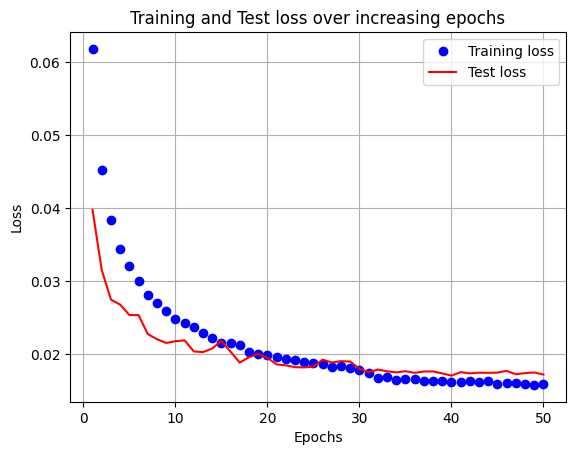

In [10]:
epochs = np.arange(50)+1


plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Test loss')
plt.title('Training and Test loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

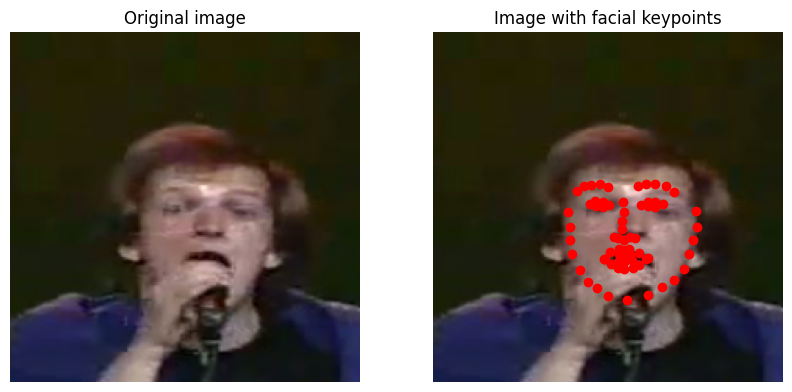

In [11]:
ix = 0
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Original image')
im = test_ds.load_img(ix)
plt.imshow(im)
plt.grid(False)
plt.axis('off')

plt.subplot(222)
plt.title('Image with facial keypoints')
x, _ = test_ds[ix]
plt.imshow(im)
kp = model(x[None].to(device)).flatten().detach().cpu()
plt.scatter(kp[:68]*224, kp[68:]*224, c='r')
plt.grid(False)
plt.axis('off')
plt.show()